In [ ]:
!pip install -q torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install -q --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
!pip install -q --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
!pip install -q --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
!pip install -q --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
!pip install torch-geometric

In [3]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from torch_geometric.data import NeighborSampler
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import collections

#from modules.model import Net
#from modules.sampling import RWSampler

In [4]:
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = data.x.to(device)
y = data.y.squeeze().to(device)

In [5]:
arr=torch.nonzero((data.train_mask == True))
indices_of_train_data = ([item for sublist in arr for item in sublist])

In [34]:
train_loader = NeighborSampler(data.edge_index, node_idx=data.train_mask, batch_size = 256, sizes=[25, 10],
                               shuffle=True)
Pos_Neg_sampler = RWSampler(data,device=device)

def train(model,data,optimizer):
    model.train()        
    total_loss = 0
    optimizer.zero_grad()
    if model.conv=='GCN':
        out = model.inference(data.to(device))
        pos_rw,neg_rw = Pos_Neg_sampler.sample(indices_of_train_data)
        loss = model.loss(out[data.train_mask], pos_rw.to(device), neg_rw.to(device))
        total_loss+=loss
    else:
        for batch_size, n_id, adjs in train_loader:
            # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
            adjs = [adj.to(device) for adj in adjs]
            out = model.forward(data.x[n_id].to(device), adjs)
            pos_rw,neg_rw = Pos_Neg_sampler.sample(list((collections.Counter((adjs[1].edge_index[1]).tolist()).keys())))
            loss = model.loss(out, pos_rw.to(device), neg_rw.to(device))
            total_loss+=loss
    total_loss.backward(retain_graph=True)
    optimizer.step()      
    return total_loss /len(train_loader)

def train_sup(model,data,optimizer):
    model.train()        
    total_loss=0
    optimizer.zero_grad()
    if model.conv=='GCN':
        out = model.inference(data.to(device))
        loss = model.loss_sup(out[data.train_mask],y[data.train_mask])
        total_loss+=loss
    else:
        for batch_size, n_id, adjs in train_loader:
            adjs = [adj.to(device) for adj in adjs]
            out = model.forward(data.x[n_id].to(device), adjs)
            loss = model.loss_sup(out,y[n_id[:batch_size]])
            total_loss+=loss
    total_loss.backward(retain_graph=True)
    optimizer.step()      
    return total_loss /len(train_loader)
    
@torch.no_grad()
def test_sup(model,data):
    model.eval()
    out = model.inference(data.to(device))
    y_true = y.cpu().unsqueeze(-1)
    y_pred = out.cpu().argmax(dim=-1, keepdim=True)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:    
        accs+=[int(y_pred[mask].eq(y_true[mask]).sum()) / int(mask.sum())]
    return accs

@torch.no_grad()
def test(model,data):
    model.eval()
    out = model.inference(data.to(device))
    y_true = y.cpu().detach().numpy()
    clf = MLPClassifier(random_state=1, max_iter=2000)
    clf.fit(out[data.train_mask].cpu().detach().numpy(),y_true[data.train_mask.cpu()])
    results = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:    
        results += [(clf.score(out.cpu().detach()[mask].numpy(), y.cpu().detach()[mask].cpu().numpy()))]
    return results

**Для начала посмотрим, что получится, если передать только фичи. Без обучения**

In [ ]:
#в датасете планетоид все фичи это 0 кроме какой-то одной, не уверена, что это актуальное сравнение 
from sklearn.metrics import accuracy_score
y_true = y.cpu().detach().numpy()
clf = MLPClassifier(random_state=1, max_iter=3000).fit(x[data.train_mask].cpu().detach().numpy(),y_true[data.train_mask])
y_pred = clf.predict(x.cpu().detach().numpy())

results = []
for mask in [data.train_mask, data.val_mask, data.test_mask]:  
    results += [(clf.score(x.cpu().detach()[mask].numpy(), y.cpu().detach()[mask].numpy()))]
log = 'Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
print(log.format(results[0], results[1], results[2]))        

**Теперь сравним с результатом после обучения эмбедингов**

GCN unsupervised
0
1
2
3
4
5
6
7
8
9
Validation acc on the last epoch  0.69


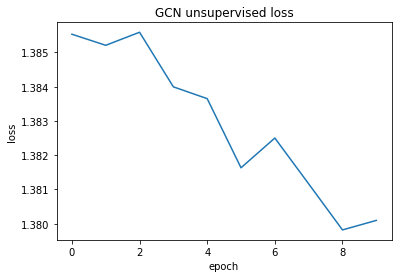

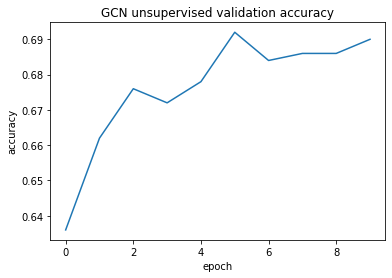

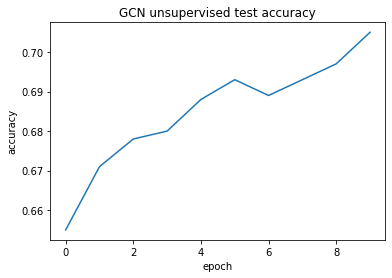

GAT unsupervised
0


c:\users\anpolol\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


c:\users\anpolol\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
3
4
5
6
7
8
9
Validation acc on the last epoch  0.776


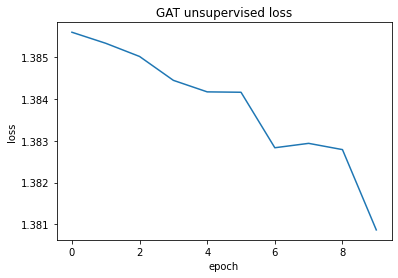

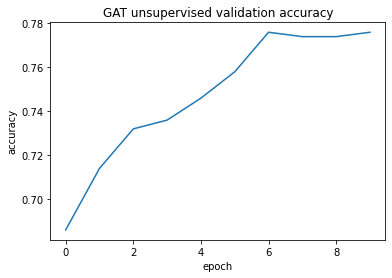

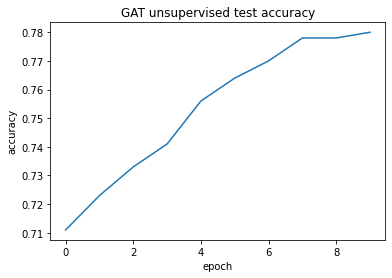

SAGE unsupervised
0


c:\users\anpolol\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


c:\users\anpolol\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


c:\users\anpolol\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


c:\users\anpolol\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


c:\users\anpolol\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


c:\users\anpolol\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


6


c:\users\anpolol\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


7


c:\users\anpolol\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


8


c:\users\anpolol\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


9
Validation acc on the last epoch  0.6


c:\users\anpolol\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


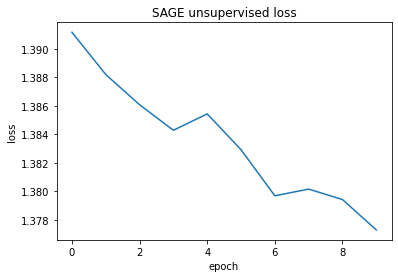

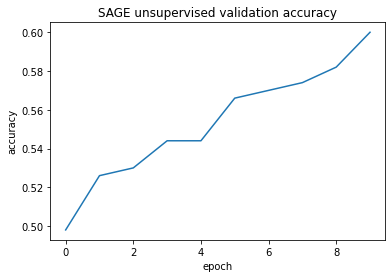

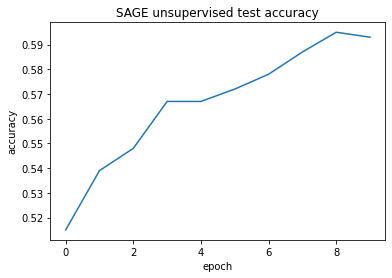

In [36]:
Pos_Neg_sampler = RWSampler(data,walk_length =5,walks_per_node=5, device=device)
models = [Net(dataset = dataset,mode='supervised',conv='GCN',device=device), Net(dataset = dataset,mode='supervised',conv='GAT',device=device),Net(dataset = dataset,mode='supervised',conv='SAGE',device=device), Net(dataset = dataset,mode='unsupervised',conv='GCN',device=device),Net(dataset = dataset,mode='unsupervised',conv='GAT',device=device),Net(dataset = dataset,mode='unsupervised',conv='SAGE',device=device)]
for i in [3,4,5]:
    model = models[i]
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    losses=[]
    train_accs=[]
    test_accs=[]
    val_accs=[]
    name_of_plot=model.conv+' '+model.mode
    print(name_of_plot)
    if model.mode=='unsupervised':
        func_train=train
        func_test=test
    elif model.mode=='supervised':
        func_train=train_sup
        func_test=test_sup
    for epoch in range(0, 10):
        print(epoch)
        loss = func_train(model,data,optimizer)
        losses.append(loss)
        train_acc, val_acc, test_acc = func_test(model,data)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        val_accs.append(val_acc)
        scheduler.step()
        log = 'Loss: {:.4f}, Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
        #print(log.format(loss, epoch, train_acc, val_acc, test_acc))
    print('Validation acc on the last epoch ', val_acc)
    plt.plot(losses)
    plt.title(name_of_plot+' loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    

    plt.plot(val_accs)
    plt.title(name_of_plot+' validation accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

    plt.plot(test_accs)
    plt.title(name_of_plot+' test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()